# **Step 1: Import Libraries & Load Dataset**

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load dataset
df = pd.read_csv('/content/Walmart.csv')
df

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...
6430,45,28-09-2012,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,05-10-2012,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,12-10-2012,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,19-10-2012,718125.53,0,56.47,3.969,192.330854,8.667


In [3]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [4]:
df.isnull().sum()

,0
Store,0
Date,0
Weekly_Sales,0
Holiday_Flag,0
Temperature,0
Fuel_Price,0
CPI,0
Unemployment,0


In [5]:
df.duplicated().sum()

np.int64(0)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [7]:
df.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


# **Step 2: Data Cleaning & Feature Engineering**

In [8]:
# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

In [9]:
# Sort values
df = df.sort_values(['Store', 'Date'])

In [10]:
# Create time-based features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week
df['Quarter'] = df['Date'].dt.quarter

In [11]:
# Check for missing values
print(df.isnull().sum())

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
Year            0
Month           0
Week            0
Quarter         0
dtype: int64


In [12]:
# Display updated DataFrame
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Week,Quarter
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,2010,2,5,1
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,2010,2,6,1
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,2010,2,7,1
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,2010,2,8,1
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,2010,3,9,1


# **Step 3: Exploratory Data Analysis (EDA)**

## **3.1 Overall Sales Trend**

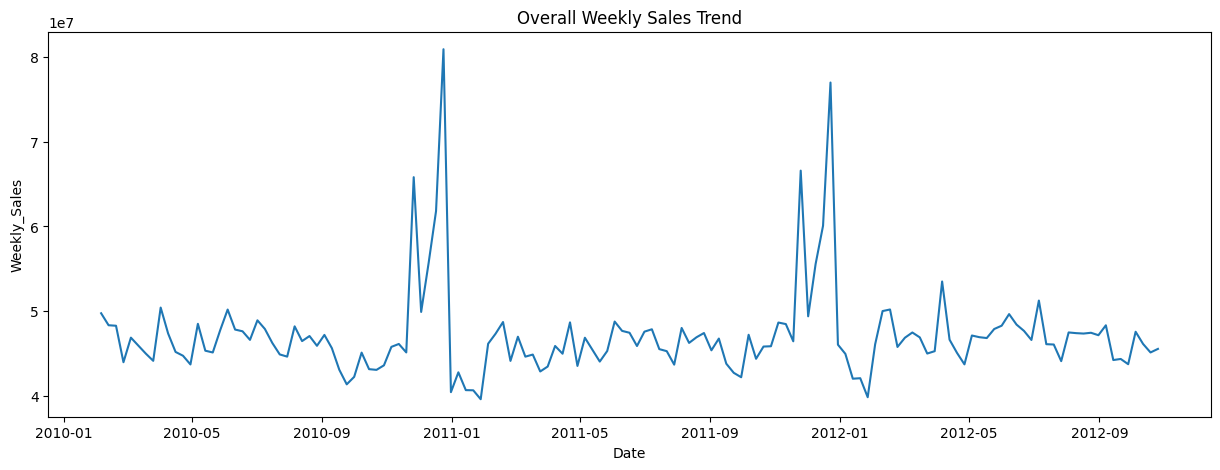

In [13]:
sales_trend = df.groupby('Date')['Weekly_Sales'].sum().reset_index()
plt.figure(figsize=(15,5))
sns.lineplot(x='Date', y='Weekly_Sales', data=sales_trend)
plt.title('Overall Weekly Sales Trend')
plt.show()

## **3.2 Correlation Heatmap**

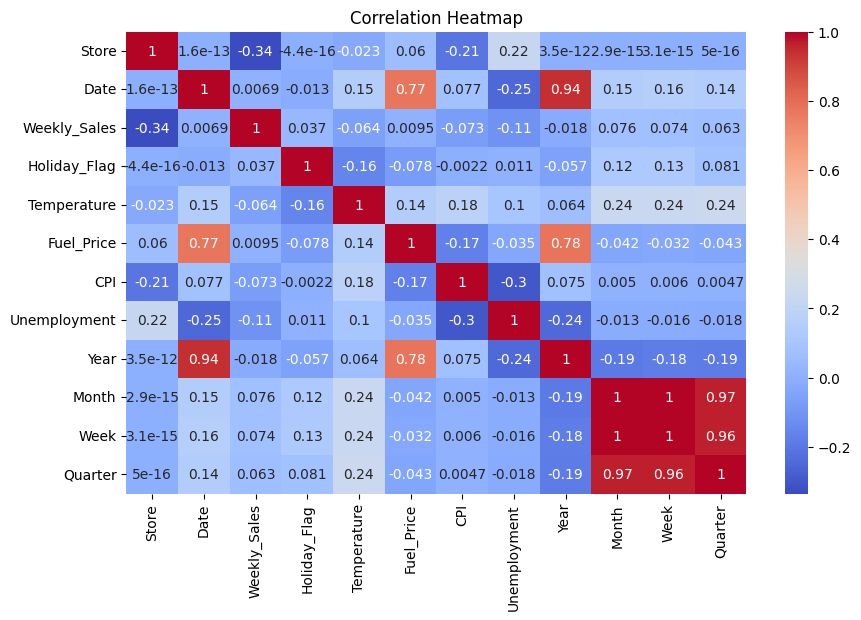

In [14]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## **3.3 Top 5 Performing Stores**

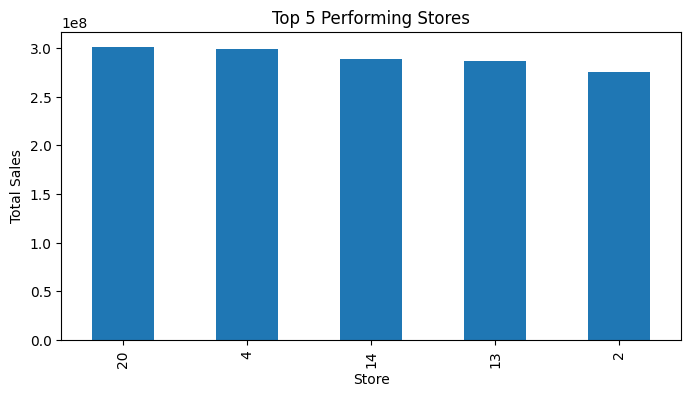

In [15]:
top_stores = df.groupby('Store')['Weekly_Sales'].sum().sort_values(ascending=False).head(5)
top_stores.plot(kind='bar', title='Top 5 Performing Stores', figsize=(8,4))
plt.ylabel('Total Sales')
plt.show()

## **3.4 Holiday vs Non-Holiday Sales**

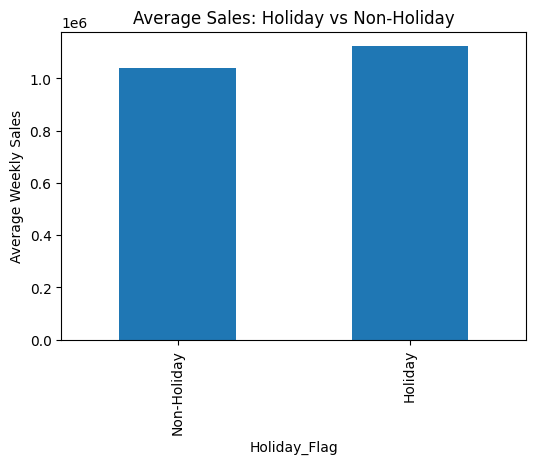

In [16]:
holiday_sales = df.groupby('Holiday_Flag')['Weekly_Sales'].mean()
holiday_sales.plot(kind='bar', title='Average Sales: Holiday vs Non-Holiday', figsize=(6,4))
plt.xticks(ticks=[0,1], labels=['Non-Holiday', 'Holiday'])
plt.ylabel('Average Weekly Sales')
plt.show()

# **Step 4: Forecasting with SARIMA (Store 1 Example)**

### **SARIMA stands for Seasonal AutoRegressive Integrated Moving Average**

### **Note for why we used it: Walmart dataset is weekly and likely shows seasonal sales patterns**

In [17]:
store1 = df[df['Store'] == 1].set_index('Date')
store1_sales = store1['Weekly_Sales'].resample('W').sum()

In [18]:
# Train-Test Split
train = store1_sales[:-12]
test = store1_sales[-12:]

In [19]:
# Fit SARIMA
model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,52))
sarima_fit = model.fit()

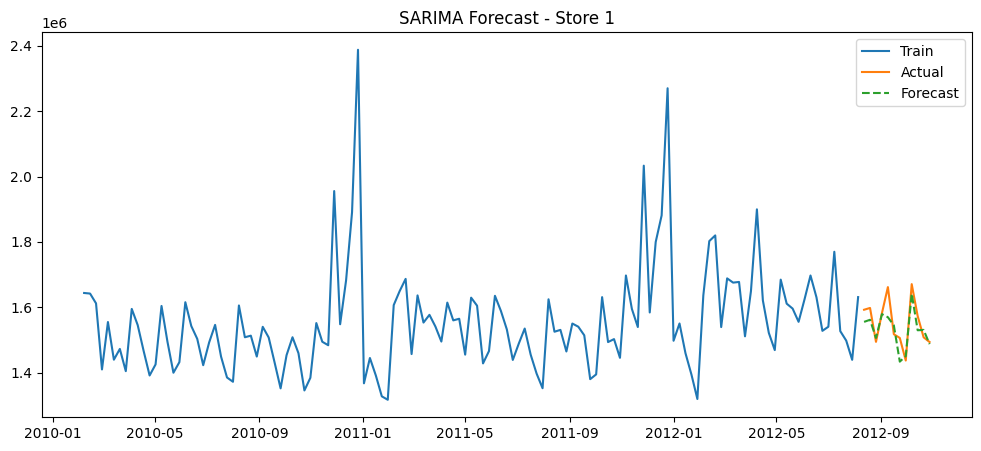

In [20]:
# Forecast
forecast = sarima_fit.forecast(steps=12)

# Plot
plt.figure(figsize=(12,5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast, label='Forecast', linestyle='--')
plt.legend()
plt.title('SARIMA Forecast - Store 1')
plt.show()

# **Step 5: Machine Learning Forecasting (Random Forest)**

In [21]:
# Feature set
features = ['Store', 'Holiday_Flag', 'Temper5ature', 'Fuel_Price', 'CPI', 'Unemployment', 'Year', 'Month', 'Week']
X = df[features]
y = df['Weekly_Sales']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')

MAE: 431472.97
RMSE: 556319.06
